#1. 所有dimension +/- c
#2. 所有dimension +/- sd
#3. selected dimension +/-
#4. /results/interpretability/cpc_z_mapping_with_polarity.csv +/- c +/- sd
#5. prior art focal claim
#6. x + alpha(y - x)


In [1]:
!pip install transformers
!pip install tensorboardX ipdb
!nvidia-smi
!pip install sentence-transformers

import os
import pickle
from google.colab import drive
drive.mount('/content/drive/',force_remount = True)
os.chdir('/content/drive/MyDrive/innovae-revision/innovae-adavae/adavae/adavae/src')

import numpy as np
import pandas as pd
import seaborn as sns

from collections import defaultdict
from scipy.stats.stats import pearsonr
from matplotlib import pyplot as plt

import torch, math, argparse, copy, re
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from torch.utils.data import DataLoader
from argparse import ArgumentParser
from transformers import GPT2Tokenizer, GPT2LMHeadModel

from adapters.configuration_gpt2 import GPT2Config
from adapters.vae import GPT2Adapter, AdaVAEModel
from adapters.common import AdapterConfig
from adaVAE import compute_loss
from data import GenerationDataset, DataFrameDataset
from utils import init_para_frompretrained, tokenize, sample_sequence, top_k_top_p_filtering

from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.4 MB/s eta 0:00:00
Wed Aug 16 01:06:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|========

FileNotFoundError: ignored

In [ ]:
# change trained information here
experiment = 'patent_claim_iter26272_as128_scalar1.0_cycle-auto_prenc-start_wsTrue_lg-latent_attn_add_attn_beta1.0_reg-kld_attn_mode-none_ffn_option-parallel_ffn_enc_layer-8_dec_layer-12_zdim-512_optFalse_ftFalse_zrate-0.5_fb-1sd-42_5.24'
latent_size = 512
max_length = 400
batch_size = 40
top_k = 100
top_p = 0.95

#Utils

In [ ]:
def decode_sent(sent):
    sent = sent[sent.index(endoftext) + 1:]
    if endoftext in sent:
        sent = sent[:sent.index(endoftext)]
    return tokenizer.decode(sent).strip()


def sample_sequence(model, length, z=None, batch_size=None,
                    temperature=1, top_k=100, top_p=0.95, device='cuda',
                    sample=True, eos_token=None, model_type='cvae', repetition_penalty=1):
    with torch.no_grad():
        # if model_type == 'cvae':
        if z is None:
            z = torch.randn([batch_size, model.AdapterConfig.latent_size], device=device)
        assert z.size() == torch.Size([batch_size, model.AdapterConfig.latent_size]), "get latent code with wrong size"

        mem = None
        prev = torch.tensor([[eos_token]] * batch_size, dtype=torch.long, device=device)

        output = prev
        probability = torch.tensor([], dtype=torch.float, device=device)
        if_end = torch.tensor([False] * batch_size, dtype=torch.bool, device=device)
        for i in range(length): #trange
            last_hidden, mem = model.transformer(input_ids=prev, past=mem, representations=z)

            logits = model.lm_head(last_hidden)
            if model.add_softmax:
                logits_rep = model.lm_head_rep(z)
                logits = logits + logits_rep.unsqueeze(dim=1)

            logits = logits[:, -1, :] / temperature
            logits = top_k_top_p_filtering(logits, top_k, top_p)

            score = torch.gather(logits, 1, output)
            score = torch.where(score < 0, score * repetition_penalty, score / repetition_penalty)
            logits.scatter_(1, output, score)

            probs = F.softmax(logits, dim=-1)
            if sample:
                next_token = torch.multinomial(probs, num_samples=1)
            else:
                _, next_token = torch.topk(probs, k=1, dim=-1)

            probability = torch.cat((probability, probs.gather(1, next_token)), dim=1)
            output = torch.cat((output, next_token), dim=1)
            prev = next_token

            # early stopping if all sents have ended once
            if_end[next_token.view(-1).eq(eos_token)] = True
            if if_end.all(): break
    return output, probability

def cosine_similarity(vectors1, vectors2):
    # normalize v1
    v1_norm = vectors1 / np.linalg.norm(vectors1, axis=1, keepdims=True)

    # normalize all vectors
    v2_norm = vectors2 / np.linalg.norm(vectors2, axis=1, keepdims=True)

    # compute cosine similarity
    cosine_similarities = v1_norm@v2_norm.T

    return cosine_similarities

def cosine_similarity_gpu(vectors1, vectors2):
    # normalize v1
    vectors1 = torch.tensor(vectors1, device = 'cuda')
    vectors2 = torch.tensor(vectors2, device = 'cuda')

    v1_norm = vectors1 / torch.norm(vectors1, dim=1, keepdim=True)

    # normalize all vectors
    v2_norm = vectors2 / torch.norm(vectors2, dim=1, keepdim=True)

    # compute cosine similarity
    cosine_similarities = torch.matmul(v1_norm, v2_norm.T)

    return cosine_similarities

#Parameters

In [ ]:
parser = ArgumentParser()

# Default parameters are set based on single GPU training
parser.add_argument("--seed", type=int, default=42)

## mode options
parser.add_argument('--adapter_size', type=int, default=128,
                    help="Hidden size of GPT2 encoder/decoder adapter")
parser.add_argument('--latent_size', type=int, default=32,
                    help="Hidden size of latent code")
parser.add_argument('--encoder_n_layer', type=int, default=8,
                    help="attention layer number of GPT-2 encoder")
parser.add_argument('--decoder_n_layer', type=int, default=12,
                    help="attention layer number of GPT-2 decoder")
parser.add_argument('--class_num', type=int, default=2,
                    help="class number for controllable generation")
parser.add_argument('--adapter_scalar', type=str, default="1.0",
                    help="adapter scalar")
parser.add_argument('--ffn_option', type=str, default="parallel_ffn",
                    choices=['sequential', 'parallel_attn', 'parallel_ffn', 'pfeiffer'],
                    help="adapter type option")
parser.add_argument('--latent_gen', type=str, default="latent_attn",
                    help="method for encoder to latent space, averaged_attn for average attention from "
                         "TransformerCVAE, linear for taken the first encoder token to a linear like Optimus",
                    choices=['latent_attn', 'averaged_attn', 'linear', 'mean_max_linear'])
parser.add_argument('--attn_mode', type=str, default="none",
                    choices=['prefix', 'adapter', 'lora', 'none'],
                    help="attention transfer type")
parser.add_argument('--reg_loss', type=str, default="kld",
                    choices=['kld', 'adversarial', 'symlog'],
                    help="regularization loss for latent space")

## testing paramters
parser.add_argument('--batch_size', type=int, default=128,
                    help='batch size per GPU. Lists the schedule.')
parser.add_argument('--max_length', type=int, default=30,
                    help='max length of every input sentence')
parser.add_argument('--data-dir', type=str, default='data/optimus_dataset')
parser.add_argument('--out-dir', type=str, default='out')
parser.add_argument('--experiment', type=str, help="ckpt dirctory", default='out')
parser.add_argument('--adapter_init', type=str, default='bert', choices=['lora', 'bert', 'lisa', 'other'],
                    help="parameter initialization method for adapter layers.")
parser.add_argument('--workers', default=2, type=int, metavar='N',  help='number of data loading workers')
parser.add_argument("--total_sents", default=10, type=int, help="Total sentences to test recontruction/generation.")
parser.add_argument("--max_test_batch", default=10, type=int, help="Total sentence pairs to test interpolation/analogy.")
parser.add_argument("--num_interpolation_step", default=10, type=int)
parser.add_argument("--degree_to_target", type=float, default=1.0)
parser.add_argument("--max_val_batches", type=int, help="Max batch size number to test recontruction.", default=30)
parser.add_argument("--latest_date", type=str, help="Latest date for model testing.", default="")

## metrics
parser.add_argument('--au_delta', type=float, default=0.01,
                    help="threshold for activated unit calculation.")

# use GPU
parser.add_argument('--gpu', default=0, type=int)
parser.add_argument('--no_gpu', action="store_true")


# KL cost annealing, increase beta from beta_0 to 1 in beta_warmup steps
parser.add_argument('--beta_0', default=1.00, type=float)
parser.add_argument('--beta_warmup', type=int, default=1000)
parser.add_argument('--kl_rate', type=float, default=0.0)

# cyc_vae parameters
parser.add_argument('--cycle', type=int, default=2000)

## trigger
parser.add_argument('--load', action="store_true")
parser.add_argument('--save_all', action="store_true", help="save full parameters of the model")
parser.add_argument('--add_input', action="store_true")
parser.add_argument('--add_attn', action="store_true")
parser.add_argument('--add_softmax', action="store_true")
parser.add_argument('--add_mem', action="store_true")
parser.add_argument('--attn_proj_vary', action="store_true")
parser.add_argument('--finetune_enc', action="store_true")
parser.add_argument('--finetune_dec', action="store_true")
parser.add_argument('--weighted_sample', action="store_true")
parser.add_argument('--add_z2adapters', action="store_true")
parser.add_argument('--learn_prior', action="store_true")
parser.add_argument('--test_model', action="store_true")
parser.add_argument('--do_sample', action="store_true", help="sample for reconstruction")

args = parser.parse_args(f'--add_attn --weighted_sample --latent_size {latent_size} --max_length {max_length} --batch_size {batch_size} --experiment {experiment}'.split())

#Load Model

In [ ]:
# Set random seed
gpu = torch.cuda.is_available()
np.random.seed(args.seed)
prng = np.random.RandomState()
torch.random.manual_seed(args.seed)

if gpu:
    print("There are ", torch.cuda.device_count(), " available GPUs!")
    torch.cuda.set_device(args.gpu)
    torch.cuda.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    print('Current single GPU: {}'.format(torch.cuda.current_device()))
device = torch.device(args.gpu if torch.cuda.is_available() else "cpu")

# Load model and trained weights
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
endoftext = tokenizer.convert_tokens_to_ids("<|endoftext|>")

config = GPT2Config()
ada_config = AdapterConfig(hidden_size=768,
                            adapter_size=args.adapter_size,
                            adapter_act='relu',
                            adapter_initializer_range=1e-2,
                            latent_size=args.latent_size,
                            class_num=args.class_num,
                            encoder_n_layer=args.encoder_n_layer,
                            decoder_n_layer=args.decoder_n_layer,
                            dis_emb=128,
                            init='other',
                            adapter_scalar=args.adapter_scalar,
                            ffn_option=args.ffn_option,
                            attn_mode=args.attn_mode,
                            latent_gen=args.latent_gen,
                            attn_option='none',
                            mid_dim=30,
                            attn_bn=25,
                            prefix_dropout=0.1,
                            tune_enc=False,
                            tune_dec=False,
                            add_z2adapters=args.add_z2adapters)

AdaVAE = AdaVAEModel(config, ada_config, add_input=args.add_input, add_attn=args.add_attn, add_softmax=args.add_softmax, add_mem=args.add_mem,
                attn_proj_vary=args.attn_proj_vary, learn_prior=args.learn_prior, reg_loss=args.reg_loss)

## load pre-trained weights
init_para_frompretrained(AdaVAE.transformer, gpt2_model.transformer, share_para=False)
init_para_frompretrained(AdaVAE.encoder, gpt2_model.transformer, share_para=False)
AdaVAE.lm_head.weight = gpt2_model.lm_head.weight
AdaVAE.eval()

## load trained parameters
print('Loading model weights...')
state = torch.load(os.path.join("./out", args.experiment, 'model_best_val.pt'))  # , map_location='cpu' model_latest.pt
if 'module' in list(state.keys())[0]:  # model_path is data parallel model with attr 'module'
    keys = copy.copy(state).keys()
    for k in keys:
        state[k.replace('module.', '')] = state.pop(k)

if not args.save_all:
    model_dict = AdaVAE.state_dict()
    additional_dict = {k: v for k, v in state.items() if k in model_dict}
    model_dict.update(additional_dict)
    AdaVAE.load_state_dict(model_dict)
else:
    AdaVAE.load_state_dict(state)
AdaVAE = AdaVAE.to(device)


# load a pre-trained model
discriminator = SentenceTransformer('/content/drive/MyDrive/innovae-revision/innovae-adavae/patent_transformer')

There are  1  available GPUs!
Current single GPU: 0


Loading model weights...


#Read Data

In [ ]:
grant = pd.read_csv('/content/drive/MyDrive/innovae-revision/innovae-adavae/data/patent_grant_cleanded_new.csv').sample(frac = 1,random_state = 10).reset_index(drop = True)
#test_grant = grant[grant['set'] == 'val'].reset_index(drop = True)
test_grant = pd.read_csv('/content/drive/MyDrive/innovae-revision/innovae-adavae/data/test_grant_reconstruct.csv')
with open('/content/drive/MyDrive/innovae-revision/innovae-adavae/results/encoded_space/data.pkl', 'rb') as f:
    sentence_space = np.array(pickle.load(f))
with open('/content/drive/MyDrive/innovae-revision/innovae-adavae/results/encoded_space/query.pkl', 'rb') as f:
    innovae_space = np.array(pickle.load(f))

#Encoding all documents

In [ ]:
train_dataloader = DataLoader(
    DataFrameDataset(test_grant),
    batch_size=args.batch_size,
    pin_memory=True,
    drop_last=False,
    num_workers=args.workers,
    shuffle = False)

if True:
  with torch.no_grad():
    encoded = []
    for i, batch in enumerate(tqdm(train_dataloader, desc="Reconstructing Documents:")):
        with torch.no_grad():
            x_ids, input_ids, attention_mask = tokenize(batch['new_text'], tokenizer, device, args)
            outputs = AdaVAE(input_ids=input_ids, attention_mask=attention_mask, from_mean=True,get_z_only = True)
            latent_z = outputs[-2]
            var = outputs[-1]
            latent_sent = discriminator.encode(batch['new_text'])
            df_batch = pd.DataFrame({'latent_z': latent_z.tolist(),
                                     'latent_sent': latent_sent.tolist(),
                                     'var':var.tolist()})
            encoded.append(df_batch)

Reconstructing Documents:: 100%|██████████| 257/257 [03:51<00:00,  1.11it/s]


In [ ]:
new_inno, new_sent, new_var = np.array(pd.concat(encoded)['latent_z'].tolist()), np.array(pd.concat(encoded)['latent_sent'].tolist()), np.array(pd.concat(encoded)['var'].tolist())

In [ ]:
prior_inno, prior_sent = np.array(pd.concat(encoded)['latent_z'].tolist()), np.array(pd.concat(encoded)['latent_sent'].tolist())

#Paired 102 Rejection Classifier

In [ ]:
pair_similarity = []
for i,j in tqdm(zip(new_sent,prior_sent)):
  out = cosine_similarity(np.expand_dims(i,0),np.expand_dims(j,0))
  pair_similarity.append(out[0][0])
pair_similarity = np.array(pair_similarity)

adjusted = [np.array(i) for i in new_sent]
dat = pd.DataFrame({'adjusted':adjusted})

train_dataloader = DataLoader(
      DataFrameDataset(dat),
      batch_size=args.batch_size,
      pin_memory=True,
      drop_last=False,
      num_workers=args.workers,
      shuffle = False)

results = []
for batch in tqdm(train_dataloader):
 result = cosine_similarity_gpu(batch['adjusted'].cpu().numpy(), sentence_space)
 result = result.topk(10000)[0]
 selected_indices = torch.multinomial(torch.ones_like(result), 100, replacement=False)
 selected_values = result.gather(1, selected_indices)
 results.append(selected_values.cpu().numpy())
 del result
 torch.cuda.empty_cache()

100%|██████████| 257/257 [05:13<00:00,  1.22s/it]


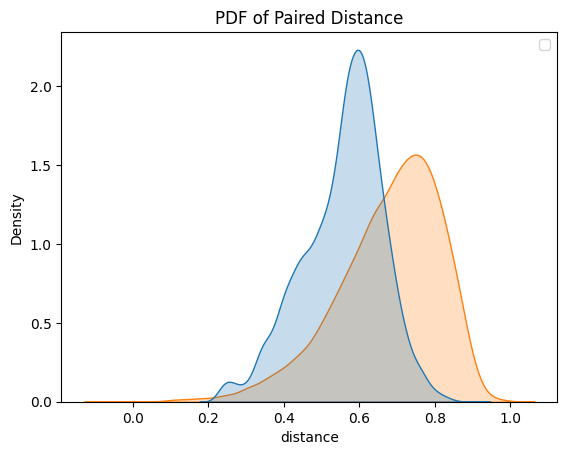

In [ ]:
sentence_similarity = np.vstack(results).flatten().tolist()
# Flatten remove_arr to a 1D list
remove_list = (np.vstack([pair_similarity for _ in range(100)]).T == np.vstack(results)).flatten().tolist()
# Now generate a new list that only contains elements not in remove_list
similarity_list = [sentence_similarity[i] for i in range(len(sentence_similarity)) if remove_list[i] == False]

distance0 = similarity_list[:10247]
distance1 = pair_similarity.tolist()
label0 = [0 for _ in range(10247)]
label1 = [1 for _ in range(10247)]

draw_data = pd.DataFrame({'distance':distance0 + distance1,
                          'label':label0 + label1})

sns.kdeplot(x = 'distance', data = draw_data, fill=True, hue = 'label')
plt.legend()
plt.title('PDF of Paired Distance')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(draw_data['distance']).reshape(-1, 1), draw_data['label'], test_size=0.1, random_state=42)
rejection_model = LogisticRegression()
rejection_model.fit(X_train, y_train)
preds = rejection_model.predict(X_test)
print(classification_report(y_test, preds))

def similarity_probability(positive_distances, negative_distances, similarity, scaler = 5):
  kde_negative = gaussian_kde(negative_distances)
  kde_positive = gaussian_kde(positive_distances)
  negative = kde_negative(similarity)*5
  positive = kde_positive(similarity)
  return positive/(negative + positive)
print(rejection_model.coef_,rejection_model.intercept_)

              precision    recall  f1-score   support

           0       0.73      0.69      0.71      1050
           1       0.69      0.73      0.71      1000

    accuracy                           0.71      2050
   macro avg       0.71      0.71      0.71      2050
weighted avg       0.71      0.71      0.71      2050



#Guided Reconstruction

In [ ]:
selected_index = pd.read_csv('/content/drive/MyDrive/innovae-revision/results/interpretability/cpc_z_mapping_with_polarity.csv')
indexs = [int(re.findall('\d+', i)[0]) for i in selected_index['top_importance_col'].tolist()]

all_result = []
for alpha in tqdm(np.linspace(-0.0,-1.11,12)):
  adjusted = [np.array(i) + alpha for i in new_inno][:3000]
  #original = [np.array(i) for i in new_inno][:3000]

  recon_dataloader = DataLoader(
      adjusted,
      batch_size=args.batch_size,
      pin_memory=True,
      drop_last=False,
      num_workers=args.workers,
      shuffle = False)

  decode = []
  for batch in tqdm(recon_dataloader):
    with torch.no_grad():
      sents, _ = sample_sequence(AdaVAE,
                                args.max_length,
                                z = torch.tensor(batch.numpy(),
                                                  dtype = torch.float32,
                                                  device = 'cuda'),
                                batch_size=40,
                                top_k=top_k,
                                top_p=top_p,
                                device=device,
                                sample=True,
                                eos_token=endoftext,
                                temperature = 0.2)
      # Sample sentences
      sents = sents.tolist()
      decoded = [decode_sent(sent) for sent in sents]
      decode += decoded
  all_result.append(decode[:])

generated_text = pd.DataFrame(all_result).T
generated_text['new_text'] = test_grant['new_text'][:3000]
generated_text['prior_text'] = test_grant['prior_text'][:3000]
generated_text.to_csv('/content/drive/MyDrive/innovae-revision/results/reconstruction/guided_constant_inno.csv', index = False)

#Distance Calculation

In [ ]:
similarities = []
for idx, row in tqdm(generated_text.iterrows()):
  prior = discriminator.encode(row['prior_text'])
  prior =  prior/np.linalg.norm(prior)
  new = discriminator.encode(row[0:10].tolist())
  new =  new/np.linalg.norm(new, axis=1, keepdims=True)
  similarities.append(prior@new.T)

sim = np.stack(similarities)

original = np.stack([sim[:,-1] for _ in range(9)]).T
guided = sim[:,:-1]

diff = guided - original

mean = diff.mean(axis = 0)
std = (diff.std(axis = 0, ddof = 1)/np.sqrt(2000))
upper_bound = mean + 1.96*std
lower_bound = mean - 1.96*std

alphas = [-0.7,-0.5, -0.3, -0.1, 0, 0.1, 0.3, 0.5, 0.7]
plt.plot(alphas,mean, label = 'Expected Value')
plt.plot(alphas,upper_bound, label = '97.5% Upper Bound')
plt.plot(alphas,lower_bound, label = '2.5% Upper Bound')
plt.xlabel('Alpha')
plt.ylabel('Change in Similarity')
plt.title('Change in Similarity with Prior Art with Respect to Original Claim')
plt.legend()
plt.show()

2000it [07:08,  4.66it/s]


In [ ]:
reconstruct_text_0 = pd.read_csv('/content/drive/MyDrive/innovae-revision/results/reconstruction/guided_inno.csv')
reconstruct_text_1 = pd.read_csv('/content/drive/MyDrive/innovae-revision/results/reconstruction/guided_constant_inno.csv')
reconstruct_text_2 = pd.read_csv('/content/drive/MyDrive/innovae-revision/results/reconstruction/guided_var_inno.csv')
reconstruct_text_3 = pd.read_csv('/content/drive/MyDrive/innovae-revision/results/reconstruction/guided_select_constant_inno.csv')
reconstruct_text_4 = pd.read_csv('/content/drive/MyDrive/innovae-revision/results/reconstruction/guided_select_var_inno.csv')
reconstruct_text_5 = pd.read_csv('/content/drive/MyDrive/innovae-revision/results/reconstruction/guided_selected_inno.csv')

In [ ]:
sentence_recons_0 = [discriminator.encode(reconstruct_text_0[i]) for i in ['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']]
sentence_recons_1 = [discriminator.encode(reconstruct_text_1[i]) for i in ['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']]
sentence_recons_2 = [discriminator.encode(reconstruct_text_2[i]) for i in ['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']]
sentence_recons_3 = [discriminator.encode(reconstruct_text_3[i]) for i in ['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']]
sentence_recons_4 = [discriminator.encode(reconstruct_text_4[i]) for i in ['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']]
sentence_recons_5 = [discriminator.encode(reconstruct_text_5[i]) for i in ['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']]
sentence_original = discriminator.encode(reconstruct_text_0['new_text'])

In [ ]:
neighbors = []
selfs = []
for i,sentence_recons in enumerate([sentence_recons_0,sentence_recons_1,sentence_recons_2,sentence_recons_3,sentence_recons_4,sentence_recons_5]):
  all_neighbors = []
  all_self = []
  for sentences in tqdm(sentence_recons):
    dat = pd.DataFrame({'adjusted': [np.array(i) for i in sentences.tolist()],
                        'original': [np.array(i) for i in sentence_original.tolist()]})

    train_dataloader = DataLoader(
        DataFrameDataset(dat),
        batch_size=args.batch_size,
        pin_memory=True,
        drop_last=False,
        num_workers=args.workers,
        shuffle = False)

    results_neighbor = []
    results_self = []
    for batch in train_dataloader:
      result_neighbor = cosine_similarity_gpu(batch['adjusted'].cpu().numpy(), sentence_space)
      result_self = [cosine_similarity_gpu(batch['adjusted'][i].unsqueeze(0),batch['original'][i].unsqueeze(0)).item() for i in range(batch['adjusted'].shape[0])]
      result_self = torch.norm(batch['adjusted'] - batch['original'], dim = 1).cpu().numpy()
      results_neighbor.append(result_neighbor.topk(200,axis = 1)[0].cpu().numpy())
      results_self.append(result_self)
      del result_neighbor
      del result_self
      torch.cuda.empty_cache()

    all_neighbors.append(results_neighbor)
    all_self.append(results_self)
  neighbors_sim = np.array([np.vstack(i) for i in all_neighbors])
  self_sim = np.array([np.vstack(i) for i in all_self])
  neighbors.append(neighbors_sim)
  selfs.append(self_sim)

In [ ]:
X = []
Y = []
Z = []
label = ['Guided','Constant','Variance','Guided Select','Constant Select','Variance Select']
for i in range(6):
  X += np.repeat(selfs_eu[i].mean(axis = (1,2)),3000).tolist()
  length = selfs_eu[i].shape[0]
  Y += neighbors[i].mean(axis = (2)).reshape(-1).tolist()
  Z += [label[i] for _ in range(3000*length)]

draw_data = pd.DataFrame({'X':X,
                          'Y':Y,
                          'Z':Z})

sns.lineplot(x = 'X', y = 'Y', data = draw_data, hue = 'Z',style = 'Z')

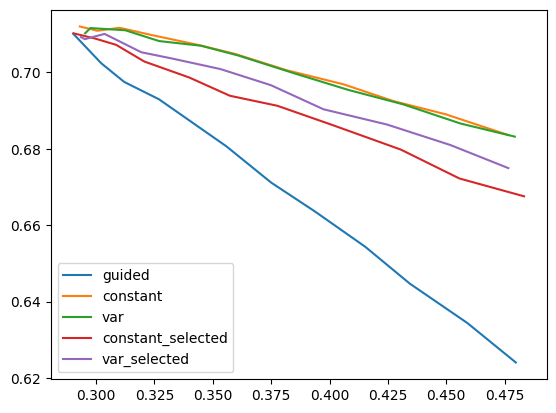

In [ ]:
plt.plot(1 - selfs[0].mean(axis = (1,2)),neighbors[0].mean(axis = (1,2)), label = 'guided')
plt.plot(1 - selfs[1].mean(axis = (1,2)),neighbors[1].mean(axis = (1,2)), label = 'constant')
plt.plot(1 - selfs[2].mean(axis = (1,2)),neighbors[2].mean(axis = (1,2)), label = 'var')
plt.plot(1 - selfs[3].mean(axis = (1,2)),neighbors[3].mean(axis = (1,2)), label = 'constant_selected')
plt.plot(1 - selfs[4].mean(axis = (1,2)),neighbors[4].mean(axis = (1,2)), label = 'var_selected')
plt.legend()
plt.show()